In [116]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [117]:
# # Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [118]:
# Read in resources
train = pd.read_csv(Path("./Resources/train.csv"))
test = pd.read_csv(Path("./Resources/test.csv"))
test_survived = pd.read_csv(Path("./Resources/gender_submission.csv"))

In [119]:
# add back survived column to test dataset
joined = pd.merge(test, test_survived, how='outer', on="PassengerId")
joined.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1


In [120]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [121]:
# Observe missing values for Age, Cabin, Embarked
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [122]:
# few missing values for Embarked; no significant loss to drop
train = train[train['Embarked'].notna()]
test = joined[joined['Embarked'].notna()]

# str astypes, just in case
for df in [train, joined]:
  df['Ticket'] = df['Ticket'].astype(str)
  df['Embarked'] = df['Embarked'].astype(str)
  df['Name'] = df['Name'].astype(str)
  df['Sex'] = df['Sex'].astype(str)

In [123]:
# fill missing age values
for df in [train, joined]:
    ages = df[df['Age'].notna()]['Age'].to_list()
    # print(np.mean(ages), np.std(ages))
    missing_age_idxs = df[df['Age'].isnull()].index.to_list()
    for idx in missing_age_idxs:
        df['Age'][idx] = random.choice(ages)

    filled = df['Age'].loc[missing_age_idxs].to_list()
    # print(np.mean(filled), np.std(filled))

# print(' ')
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        202 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.6+ KB


In [124]:
# convert SibSp and Parch to two new columns: num_related and has_related
for df in [train, joined]:
    df['num_related'] = df['SibSp'] + df['Parch']
    df['has_related'] = df['num_related'] > 0

# check results
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_related,has_related
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,True


In [125]:
# convert Ticket to has_special_ticket; check if the Ticket value has any non-number characters: true if yes, false if no
for df in [train, joined]:
    df['has_special_ticket'] = df['Ticket'].str.extract(r"([A-Za-z])")
    df['has_special_ticket'].fillna(False, inplace=True)
    df['has_special_ticket'] = df['has_special_ticket'].astype(bool)
    df.drop('Ticket', inplace=True, axis=1)

# check results
train['has_special_ticket'].value_counts()

has_special_ticket
False    659
True     230
Name: count, dtype: int64

In [126]:
# just in case, create a separate table with only the rows where cabin is truthy
cabin_train = train[train['Cabin'].notna()]
cabin_test = joined[joined['Cabin'].notna()]

# note that the reduced cabin dataset still has >100 rows,
# meeting the threshold for the assignment
print(len(cabin_train), len(train))

202 889


In [127]:
# break cabin up into letter and number component
for df in [cabin_train, cabin_test]:
    df['cabin_deck'] = df['Cabin'].str.extract(r"([A-Za-z])")
    df['cabin_num'] = df['Cabin'].str.extract(r"([0-9]+)")
    df.drop('Cabin', inplace=True, axis=1)

for df in [train, joined]:
    df.drop('Cabin', inplace=True, axis=1)

In [128]:
# check results
# cabin_train['cabin_num'].value_counts()
cabin_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,num_related,has_related,has_special_ticket,cabin_deck,cabin_num
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,True,True,C,85
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,True,False,C,123
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,0,False,False,E,46


In [129]:
# drop name (?)
for df in [cabin_train, cabin_test, train, joined]:
    df.drop('Name', inplace=True, axis=1)
    df.drop('PassengerId', inplace=True, axis=1)
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,num_related,has_related,has_special_ticket
0,0,3,male,22.0,1,0,7.2500,S,1,True,True
1,1,1,female,38.0,1,0,71.2833,C,1,True,True


In [130]:
# create X and y variables for each set using target col
train_X = train.drop('Survived', axis=1)
train_y = train['Survived']

test_X = joined.drop('Survived', axis=1)
test_y = joined['Survived']

cabin_train_X = cabin_train.drop('Survived', axis=1)
cabin_train_y = cabin_train['Survived']

cabin_test_X = cabin_test.drop('Survived', axis=1)
cabin_test_y = cabin_test['Survived']

In [131]:
# use dummies for categorical columns; have to call out some explicitly
# ex: Pclass is a number, but is in fact categorical
dummy_cols = ['Pclass', 'Embarked', 'Sex']
dummy_train = pd.get_dummies(train_X, columns=dummy_cols)
dummy_test = pd.get_dummies(test_X, columns=dummy_cols)

# attempt to treat cabin_deck as categorical
dummy_cols.append('cabin_deck')
dummy_cabin_train = pd.get_dummies(cabin_train_X, columns=dummy_cols)
dummy_cabin_test = pd.get_dummies(cabin_test_X, columns=dummy_cols)

dummy_test.head(3)

,Age,SibSp,Parch,Fare,num_related,has_related,has_special_ticket,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,34.5,0,0,7.8292,0,False,False,False,False,True,False,True,False,False,True
1,47.0,1,0,7.0000,1,True,False,False,False,True,False,False,True,True,False
2,62.0,0,0,9.6875,0,False,False,False,True,False,False,True,False,False,True


In [132]:
# use scaler to scale numerical data
scaler = StandardScaler()

train_scaler = scaler.fit(dummy_train)
train_scaled = train_scaler.transform(dummy_train)

test_scaler = scaler.fit(dummy_test)
test_scaled = test_scaler.transform(dummy_test)

cabin_train_scaler = scaler.fit(dummy_cabin_train)
cabin_train_scaled = cabin_train_scaler.transform(dummy_cabin_train)

cabin_test_scaler = scaler.fit(dummy_cabin_test)
cabin_test_scaled = cabin_test_scaler.transform(dummy_cabin_test)

In [133]:
# save X and y sets to CSV
names = ['train_scaled', 'test_scaled', 'cabin_train_scaled', 'cabin_test_scaled']

i = 0
for scaled in [train_scaled, test_scaled, cabin_train_scaled, cabin_test_scaled]:
  pd.DataFrame(scaled).to_csv(f"./Resources/{names[i]}_X.csv")
  i += 1

i = 0
for y in [train_y, test_y, cabin_train_y, cabin_test_y]:
  pd.DataFrame(y).to_csv(f"./Resources/{names[i]}_y.csv")
  i += 1

In [134]:
pd.DataFrame(test_scaled).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.314794,-0.499470,-0.400248,-0.497811,-0.553443,-0.807573,-0.641999,-0.586559,-0.534933,0.957826,-0.568142,2.843757,-1.350676,-0.755929,0.755929
1,1.208706,0.616992,-0.400248,-0.512660,0.105643,1.238278,-0.641999,-0.586559,-0.534933,0.957826,-0.568142,-0.351647,0.740370,1.322876,-1.322876
2,2.281401,-0.499470,-0.400248,-0.464532,-0.553443,-0.807573,-0.641999,-0.586559,1.869391,-1.044031,-0.568142,2.843757,-1.350676,-0.755929,0.755929


In [135]:
full_set = full_set[full_set['Fare'].notna()]

In [136]:
# merge premade train/test sets to see if we
# can get distinct results with our own split
full_set = pd.concat([train, joined])
full_set = full_set.sample(frac=1).reset_index(drop=True)
full_set = full_set[full_set['Fare'].notna()]
full_set.to_csv("./Resources/Titanic_full_dataset.csv")
full_set.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,num_related,has_related,has_special_ticket
0,1,1,female,22.0,0,0,151.5500,S,0,False,False
1,0,3,male,55.0,0,0,7.2292,C,0,False,False
2,0,3,male,41.0,0,0,7.2250,C,0,False,False


In [137]:
# replicate process from above for this newly split set
X = full_set.drop('Survived', axis=1)
y = full_set['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y)

dummy_cols = ['Pclass', 'Embarked', 'Sex']
dummy_train_full = pd.get_dummies(X_train, columns=dummy_cols)
dummy_test_full = pd.get_dummies(X_test, columns=dummy_cols)

full_train_scaler = scaler.fit(dummy_train_full)
full_train_scaled = full_train_scaler.transform(dummy_train_full)

full_test_scaler = scaler.fit(dummy_test_full)
full_test_scaled = full_test_scaler.transform(dummy_test_full)

# names = ['reset_X_train', 'reset_X_test', 'reset_y_train', 'reset_y_test']
# i = 0
# for data in [full_train_scaled, full_test_scaled, y_train, y_test]:
#   pd.DataFrame(data).to_csv(f"./Resources/{names[i]}.csv")
#   i += 1

In [138]:
full_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1306 entries, 0 to 1306
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            1306 non-null   int64  
 1   Pclass              1306 non-null   int64  
 2   Sex                 1306 non-null   object 
 3   Age                 1306 non-null   float64
 4   SibSp               1306 non-null   int64  
 5   Parch               1306 non-null   int64  
 6   Fare                1306 non-null   float64
 7   Embarked            1306 non-null   object 
 8   num_related         1306 non-null   int64  
 9   has_related         1306 non-null   bool   
 10  has_special_ticket  1306 non-null   bool   
dtypes: bool(2), float64(2), int64(5), object(2)
memory usage: 104.6+ KB


In [139]:
# Import the LogisticRegression module from SKLearn
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit the model using training data
lr_model = logistic_regression_model.fit(full_train_scaled, y_train)

In [140]:
full_test_scaled

array([[ 0.74146842, -0.51696412, -0.4475122 , ...,  0.66372331,
         1.38551177, -1.38551177],
       [ 0.81407411, -0.51696412, -0.4475122 , ..., -1.50665192,
        -0.72175497,  0.72175497],
       [ 1.17710257, -0.51696412, -0.4475122 , ..., -1.50665192,
         1.38551177, -1.38551177],
       ...,
       [-0.8558568 , -0.51696412, -0.4475122 , ..., -1.50665192,
         1.38551177, -1.38551177],
       [ 0.8866798 ,  0.55295529,  0.68687919, ...,  0.66372331,
        -0.72175497,  0.72175497],
       [-1.07367388,  0.55295529, -0.4475122 , ..., -1.50665192,
         1.38551177, -1.38551177]])

In [141]:
training_predictions = lr_model.predict(full_train_scaled)
testing_predictions = logistic_regression_model.predict(full_test_scaled)

In [142]:
from sklearn.metrics import confusion_matrix, classification_report

In [143]:
training_matrix = confusion_matrix(y_train, training_predictions)
print(training_matrix)

test_matrix = confusion_matrix(y_test, testing_predictions)
print(test_matrix)

[[548  60]
 [ 83 288]]
[[187  19]
 [ 33  88]]


In [144]:
training_report = classification_report(y_train, training_predictions)
print(training_report)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       608
           1       0.83      0.78      0.80       371

    accuracy                           0.85       979
   macro avg       0.85      0.84      0.84       979
weighted avg       0.85      0.85      0.85       979



In [145]:
testing_report = classification_report(y_test, testing_predictions)
print(testing_report)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       206
           1       0.82      0.73      0.77       121

    accuracy                           0.84       327
   macro avg       0.84      0.82      0.82       327
weighted avg       0.84      0.84      0.84       327



In [185]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(full_train_scaled, y_train)
clf.predict(full_train_scaled)

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,

In [150]:
 from sklearn.datasets import load_iris
 from sklearn import tree
 iris = load_iris()
 X, y = iris.data, iris.target
 clf = tree.DecisionTreeClassifier()
 clf = clf.fit(full_train_scaled, y_train)

In [151]:
%pip install python-graphviz

ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


[Text(0.41209272904829547, 0.975, 'x[14] <= -0.293\ngini = 0.471\nsamples = 979\nvalue = [608, 371]'),
 Text(0.1493252840909091, 0.925, 'x[9] <= -0.091\ngini = 0.287\nsamples = 352\nvalue = [61, 291]'),
 Text(0.05113636363636364, 0.875, 'x[0] <= -1.891\ngini = 0.062\nsamples = 187\nvalue = [6, 181]'),
 Text(0.03409090909090909, 0.825, 'x[7] <= 0.592\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.028409090909090908, 0.775, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.03977272727272727, 0.775, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.06818181818181818, 0.825, 'x[3] <= -0.137\ngini = 0.053\nsamples = 185\nvalue = [5, 180]'),
 Text(0.05113636363636364, 0.775, 'x[0] <= 1.789\ngini = 0.137\nsamples = 54\nvalue = [4, 50]'),
 Text(0.03409090909090909, 0.725, 'x[1] <= -0.005\ngini = 0.109\nsamples = 52\nvalue = [3, 49]'),
 Text(0.017045454545454544, 0.675, 'x[0] <= -0.378\ngini = 0.053\nsamples = 37\nvalue = [1, 36]'),
 Text(0.011363636363636364, 0.625, 'x[0] <= -0.447\ng

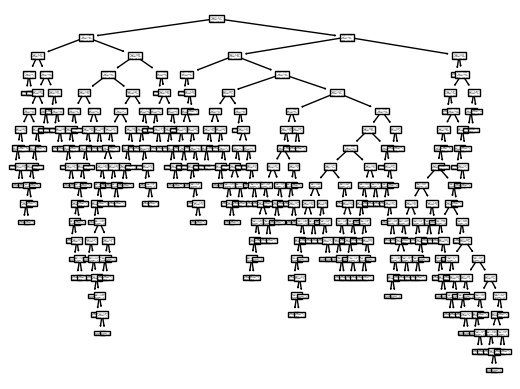

In [152]:
tree.plot_tree(clf)

In [153]:
import graphviz

In [154]:
dot_data = tree.export_graphviz(clf, out_file=None)

In [155]:
graph = graphviz.Source(dot_data)

In [156]:
graph.render("iris")

'iris.pdf'

In [157]:
%pip install catboost

In [158]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [159]:
#X_train, X_test, y_train, y_test = train_test_split(test_size=0.2, random_state=42)

# Initialize CatBoost classifier
model_catboost = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='Logloss')

# Train the model
model_catboost.fit(full_train_scaled, y_train, eval_set=(full_test_scaled, y_test), verbose=False)

# Make predictions
y_pred = model_catboost.predict(full_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8623853211009175


In [184]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                         n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)
clf.fit(full_train_scaled, y_train)
# AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=0)
# clf.predict([[0, 0, 0, 0]])
# array([1])
clf.score(full_test_scaled, y_test)

0.8409785932721713

In [160]:
import tensorflow as tf

In [161]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features_num = len(full_train_scaled[0])
layer1_nodes = 60
layer2_nodes = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=layer1_nodes, input_dim=input_features_num, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=layer2_nodes, activation="sigmoid"))

nn.add(tf.keras.layers.Dense(units=layer2_nodes, activation="sigmoid"))

# Output layer; sigmoid chosen due to binary nature of target
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 60)                960       
                                                                 
 dense_9 (Dense)             (None, 30)                1830      
                                                                 
 dense_10 (Dense)            (None, 30)                930       
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 3751 (14.65 KB)
Trainable params: 3751 (14.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [162]:
nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

In [163]:
fit_model = nn.fit(full_train_scaled,y_train,epochs=125)

Epoch 1/125
31/31 [==============================] - 1s 2ms/step - loss: 0.6601 - accuracy: 0.6210
Epoch 2/125
31/31 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.6251
Epoch 3/125
31/31 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.7886
Epoch 4/125
31/31 [==============================] - 0s 2ms/step - loss: 0.4408 - accuracy: 0.8519
Epoch 5/125
31/31 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8539
Epoch 6/125
31/31 [==============================] - 0s 3ms/step - loss: 0.3708 - accuracy: 0.8631
Epoch 7/125
31/31 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8672
Epoch 8/125
31/31 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.8672
Epoch 9/125
31/31 [==============================] - 0s 2ms/step - loss: 0.3485 - accuracy: 0.8713
Epoch 10/125
31/31 [==============================] - 0s 2ms/step - loss: 0.3447 - accuracy: 0.8723
Epoch 11/

In [164]:
model_loss, model_accuracy = nn.evaluate(full_test_scaled, y_test, verbose = 2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

11/11 - 0s - loss: 0.4288 - accuracy: 0.8349 - 239ms/epoch - 22ms/step
Loss: 0.42884156107902527, Accuracy: 0.8348624110221863


In [165]:
nn.save("Titanic.h5")